<h1><center>DSA 4212: Year 2021</center></h1>
<h3><center> Assignment 1 (Deadline: 28 March 2021 at 23:59) </center></h3>
<h3><center> To Be submitted on the lumiNUS )</center></h3>
<h2><center> Group Number: 32 </center></h2>
<h2><center> Filename: assignment_1_XXXX.ipynb where XXX is your group number</center></h2>
<h2><center> Group Member 1: Neo Zheng Jie Reo, A0183286W </center></h2>





The goal of this assignment is to explore 3 optimization methods that do NOT use any derivative information: 
1. **Particle swarm optimization**: https://en.wikipedia.org/wiki/Particle_swarm_optimization
2. **Simulated annealing**: https://en.wikipedia.org/wiki/Simulated_annealing
3. **Nelder-Mead**: https://en.wikipedia.org/wiki/Nelder–Mead_method

Start to read about these methods on wikipedia, as well as any other source [books / articles / blogs / etc...] that you seem appropriate. Describe as clearly as possible how these methods work and implement then from scratch. Explore the importance of the several tuning parameters. Discuss the advantage and drawbacks of these classes of methods and test them on some of the examples presented here: https://en.wikipedia.org/wiki/Test_functions_for_optimization


**Remark:**
1. acknowledge **all** the sources you are using to create this report. 
2. the clarity and readability of the report is important.
3. read widely and experiment.
4. It may be interesting/useful to create animations: the python package Celluloid is particularly easy to use [there are many others]

## Introduction

Gradient-based optimization methods are widely used in the field of machine learning today. With the backpropagation algorithm and use of computational graphs, gradient-based methods have become highly scalable and exclusively used to train deep networks which may contain billions of parameters. Gradients allow us to understand the local topology of the function that is being optimized but is not always available. Many problems are inherently discrete in nature and cannot be easily expressed as smooth and continuous functions. This report discusses three different optimization methods that do not require the use of gradients in the optimization procedure. In addition to understanding the mechanics and Python Implementation, they will also be evaluated on optimization test functions to evaluate their ability to find the speed, convergence rate and ability to find the global minimum



## Particle Swarm Optimisation


Particle Swarm Optimization (PSO) is a heuristic where the search space is populated by a large number of "particles" which are essentially initial guesses for where the global minimum might be. These particles are initialized with a uniformly distributed position and velocity over the entire search space. At each iteration, the velocity of the particles can be adjusted based on:
1. The optimal location which the particle has visited
2. The optimal location which has been visited by another particle in the swarm

By utilising the "wisdom of the crowd", the swarm should ideally converge towards the global optima of the function.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation
import random
import math

from IPython.display import HTML

### Python Implementation

For the Python Implementation of the 3 algorithms, they wll have an `__init__` function where the hyperparameters of the algorithm will be set. Firstly, the algorithm will be instantiated as a Python Class and will have two primary methods which are the `__init__` method which will instantiate the hyperparameters and `optimize` method. This optimize method will take in 3 parameters which are:

1. `f` - (`function`) Function that is supposed to optimize
2. `lbs` - (`list`) Python List which contains the upper bounds for the search space
3. `ubs` - (`list`) Python List which contains the lower bounds for the search space

The lists lbs and ubs is necessary for this case to set the search space for the particles to be uniformly distributed. 


For the PSO algorithm, an additional Python Class `Particle` will be created as well. Since all the particles behave identically, having a `Particle` class will make the code a lot simpler. There are three important parameters which will determine the behavior of the algorithm. These parameters are:

1. Learning Rate - How much does the velocity of the particle affect its movement
2. $\phi_g$ - How much is the velocity affected by the optima that the entire swarm 
3. $\phi_p$ - How much the velocity of a particle is affected by optima that the particle has visited



In [30]:
l_r  = 0.1
w = 0.5
phi_g = 0.15
phi_p = 0.15

PSO_params = {
    "l_r":l_r,
    "w":w,
    "phi_g":phi_g,
    "phi_p":phi_p,
    "particles":100
}

class PSO():
    def __init__(self,n_iter = 100, l_r=0.3, w=0.5, phi_g=0.3, phi_p=0.3, n_particles=100):
        self.l_r = l_r
        self.w = w
        self.phi_g = phi_g
        self.phi_p = phi_p
        self.n_particles = n_particles
        self.n_iter = n_iter

    def optimize(self,f,lbs,ubs,log = False):
        assert len(lbs) == len(ubs),"Dimension of Search Space has to be the same size"
        positions = self.particle_init(f,lbs,ubs)
        if log:
            position_list = [positions]
        for i in range(self.n_iter):
            if log: positions = []
            #Update Velocity of all the Particles
            for p in self.particles:
                p.update_velocity(self.swarm_argmin)
                p.move()
                if p.get_min() < self.swarm_min:
                    self.swarm_argmin = p.get_argmin()
                    self.swarm_min = p.get_min()
                if log: positions.append(p.get_pos())
            if log: position_list.append(positions)
            if not i%100:
                print(f"OPTIMA: f{self.swarm_argmin} = {self.swarm_min}")
        if log:
            return self.swarm_argmin,self.swarm_min, position_list
        else:
            
            return self.swarm_argmin,self.swarm_min

    def particle_init(self,f,lbs,ubs):
        self.swarm_min = float("inf")
        self.swarm_argmin = np.zeros(len(lbs))
        pos_init = np.random.uniform(lbs,ubs,size=(self.n_particles,len(lbs)))
        self.particles = []
        for pos in pos_init:
            new_particle =  Particle(
                l_r=l_r, w=w, phi_g=phi_g, f=f,
                phi_p=phi_p, position=pos)
            
            self.particles.append(new_particle)
        return pos_init
        
class Particle():
    def __init__(self, l_r, w, phi_g, phi_p, position, f):
        self.position = position
        self.dim = len(position)
        self.f = f
        self.min = self.eval_current_position()
        self.init_velocity()
        self.argmin = position
        self.l_r = l_r
        self.w = w
        self.phi_g=phi_g
        self.phi_p = phi_p
    
    def init_velocity(self):
        self.velocity = np.random.uniform(size = self.dim)
    
    def move(self):
        self.position += self.l_r*self.velocity
        if self.eval_current_position()  < self.min:
            self.min = self.eval_current_position()
            self.argmin = self.position

    def update_velocity(self,swarm_argmin):
        
        swarm_diff = swarm_argmin - self.position
        particle_diff = self.argmin - self.position
        self.velocity = self.velocity*w + swarm_diff*self.phi_g + particle_diff*self.phi_p

    def eval_current_position(self):
        return self.f(self.position)

    def get_argmin(self):
        return self.argmin
    
    def get_min(self):
        return self.min

    def __repr__(self):
        return(str(self.position))
    def get_pos(self):
        return self.position


#Defining Test Functions

def ackley(x):
    exp_1 = -0.2*(0.5*(x[0]**2+x[1]**2))**0.5
    exp_2 = 0.5*(math.cos(2*math.pi*x[0])+math.cos(2*math.pi*x[1])) 
    return -20*math.exp(exp_1)-math.exp(exp_2)+math.exp(1)+20

def rosenbrock_1(x):
    return 100*(x[1] - x[0]**2)**2 + (1-x[0])**2

def rosenbrock_2(xs):
    #Generalized Rosenbrock Function to n dimensions
    result = 0 
    for i in range(len(xs)-1):
        result +=  100*(xs[i+1] - xs[i]**2)**2 + (1-xs[i])**2
    return result
    
        
        


In [31]:
rosenbrock_2(np.ones(5))

0.0

In [32]:
model = PSO(n_particles = 50)
lbs = np.array(np.ones(2)*-2)
ubs = np.array(np.ones(2)*3)
result = model.optimize(rosenbrock_1,lbs,ubs,True)

OPTIMA: f[-0.71930521  0.48696192] = 3.0486580005624657


In [29]:
result

(array([1.00005964, 1.00011954]),
 3.5633916603448106e-09,
 [array([[1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.00011954],
         [1.00005964, 1.0001195

In [6]:
i = 5
if not i%500: print(i)

## Simulated Annealing

Simulated Annealing (SA) is a probabilistic approach to an optimization problem. SA only finds an approximate global optimum for a function and is extremely effective at solving combinatorial or discrete optimization problems. The SA algorithm is inspired by annealing in metallurgy where successive heating and cooling allows will ultimately produce the best result. Similarly the algorithm functions by varying a `temperature` parameter throughout the process. The `temperature` parameter determines how likely it is for the algorithm to choose a low probability solution, high `temperature` allows the algorithm to explore the search space more and as the `temperature` cools

As mentioned earlier, SA is best utilized for combinatorial or discrete problems and thus alterations must be made to use SA for continuous functions. One important requirement for SA to function is to have neighbouring states which allows the algorithm to search the relevant neighbours at each iteration. Since the test functions that are being used are continuous in nature, they will be discretized into specific intervals of length $\epsilon$. At each step, the neighbouring states will be $\pm\epsilon$ and the transition probability uniformly divided amongst all possible transitions. Essentially this algorithm can be thought of as a random walk on the coordinate space where the probability of accepting a worse solution gradually decreases as the temperature decreases.

For this implementation of the SA algorithm, the following Probability Distribution will be used
$$
P = \Bigg \{ 
\begin{matrix}
1 & if \ \Delta c\leq 0 \\
e^{-\Delta c /t} & if \ \Delta c\leq 0
\end{matrix}
$$
if the neighbour results in a more optimal solution, the new point will be adopted but if the function value is higher, the probability of accepting the new point will depend on the difference in cost. Another important detail is the decay function for the temperature. For this we will look at two decay functions:
1. Linear Decay:
$$ t_{n+1} = t_n -\alpha$$
2. Geometric Decay:
$$ t_{n+1} = \alpha t_n$$



### Python Implementation

For the Python Implementation of the SA algorithm, it will follow a similar structure to the PSO algorithm. The main difference is that the `optimize` method will only require an initial guess to start the algorithm since the algorithm is used for unconstrained optimization. 

In [7]:
class SimulatedAnnealing():
    def __init__(self,n_iter,initial_temp,final_temp,alpha,epsilon,decay = "linear"):
        self.n_iter = n_iter
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = "linear"
        
    
    def optimize(self,f,x0):
        temp = self.initial_temp
        solution = x0
        for i in range(self.n_iter):
            neighbours = self.get_neighbours(solution)
            new_point = random.choice(neighbours)
            cost = f(solution) - f(new_point)
            if cost> 0:
                solution = new_point
            else:
                if random.uniform(0, 1) < math.exp(cost / temp):
                    solution = new_point
            if not i% 100:
                print(new_point,f(new_point))
            temp = self.temperatureDecay(temp)
        return solution
        
    def get_neighbours(self,current_point):
        # Get the neighbours of the current point 
        # The number of neighbours should be 2^{dim} whe
        points = [[current_point[0]+self.epsilon],
                  [current_point[0]-self.epsilon]]
        for coord in current_point[1:]:
            new_set = []
            high = coord + self.epsilon
            low = coord - self.epsilon
            for combination in points:
                new_set.append(combination+[high])
                new_set.append(combination+[low])
            points = new_set.copy()
        return points
    
    def temperatureDecay(self,temp):
        if self.decay == "linear":
            temp = temp - self.alpha
        elif self.decay == "geometric":
            temp = self.alpha * temp
        if temp <= self.final_temp:
            return self.final_temp
        else:
            return temp
        

In [8]:
SA = SimulatedAnnealing(1000,50,0.5,0.99,0.01,decay = "linear")
SA.optimize(rosenbrock_1,[2.5,2.5])

[2.51, 2.51] 1438.765900999999
[2.1100000000000083, 2.549999999999999] 363.03054100001384
[1.6400000000000103, 2.6599999999999966] 0.49721600000023314
[1.6700000000000104, 2.7099999999999955] 1.0714210000006301
[1.6900000000000104, 2.9499999999999904] 1.3578209999991737
[1.7200000000000104, 2.9999999999999893] 0.6914559999996295
[1.7200000000000104, 2.919999999999991] 0.6658560000003577
[1.6400000000000103, 2.7999999999999936] 1.628415999999127
[1.7100000000000104, 2.8499999999999925] 1.053181000000654
[1.7300000000000104, 2.9499999999999904] 0.7169410000004072


[1.7300000000000104, 2.9499999999999904]

## Nelder-Mead Method
The Nelder-Mead method is a heuristic search method which uses a simplex as the search area to slowly converge onto the optimum value. Mathematically, a simplex is a $n$ dimensional object which consists of having $n+1$ vertices. The method initializes $n+1$ test points around the search function which is arranged in a simplex. By evaluating the function at the $n+1$ test points, the function can be approximated and extrapolated to derive a new test point with a lower value. This more optimal point will then replace the worst point in the simplex and this process is repeated until convergence is met.

There are many possible implementations of the Nelder-Mead method and the source of variation mainly stems from the different methods in which a new point can be extrapolated. In this implementation, the original steps from https://academic.oup.com/comjnl/article/7/4/308/354237 will be used together with the hyperparamters which were used in the paper




### Python Implementation


In [9]:
class NelderMead():
    def __init__(self,max_iter,alpha=1,gamma=2,rho=0.5,sigma=0.5):
        self.max_iter = max_iter
        self.alpha = alpha
        self.gamma = gamma
        self.rho = rho
        self.sigma = sigma
        
    def optimize(self,f,lbs,ubs,log = False):
        dim = len(lbs)
        #Choose n+1 Random Points, 
        if log: all_points = []
        points = np.random.uniform(lbs,ubs,size = (dim+1,dim))
        for i in range(self.max_iter):
            if log: all_points.append(points)
            #Step 1: Order the Points
            order = np.argsort(np.array([f(i) for i in points]))
            x_n1 = points[order[-1]] #Worst Point
            x_n = points[order[-2]]
            x_1 = points[order[0]]
            #Step 2: Calculate the Centroid of the Points
            centroid = points[order][:-1].mean(axis = 1)
            #Step 3: Reflection - Calculate Coordinates of Reflected Point
            x_r = centroid + self.alpha*(centroid - x_n1)
            #if reflected point better than second worst and not best point
            if f(x_r) >= f(x_1) and f(x_r) < f(x_n):
                points[order[-1]] = x_r
                continue
            # Step 4: Expansion
            elif f(x_r) <  f(x_1):
                x_e = centroid + self.gamma*(x_r - centroid)
                if f(x_e) < f(x_r):
                    points[order[-1]] = x_e
                else:
                    points[order[-1]] = x_r
                continue
            #Step 5: Contraction
            else:
                x_c = centroid + self.rho*(x_n1-centroid)
                if f(x_c) < f(x_n1):
                    points[order[-1]] = x_c
                    continue
                else:
                    new_points = points[order][1:]
                    #Subtraction using Numpy Broadcasting
                    new_points = x_1+ self.sigma*(points-x_1)
                    points = new_points    
        best = points[np.argsort(np.array([f(i) for i in points]))[-1]]
        if log: return best,all_points
        return best
    


## Animation

Animations can help to visualise how the algorithm works and understand how it arrives at a particular optima. These animations are done using `matplotlib.animation` package and show the behavior of the algorithms on the 2-D test functions. The animation functions can be used on the 

In [10]:
def animate_neldermead(low,high,f = rosenbrock_1):
    x = y = np.linspace(low,high)
    grid =np.meshgrid(x,y)
    z = f(grid)
    fig,ax = plt.subplots(figsize=(8,6))
    
    
    model = NelderMead(20)
    best,points = model.optimize(f,[low,low],[high,high],True)
    def init():
        ax.contour(x,y,z,levels = 25)
        poly = Polygon(points[0],True)
        ax.add_patch(poly)
    def animate(i):
        del(ax.patches[0])
        poly = Polygon(points[i],True)
        ax.add_patch(poly)
        
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=len(points), repeat = True)
    return anim.to_html5_video()
    
def animate_pso(low,high,f = rosenbrock_1):
    x = y = np.linspace(low,high)
    grid =np.meshgrid(x,y)
    z = f(grid)

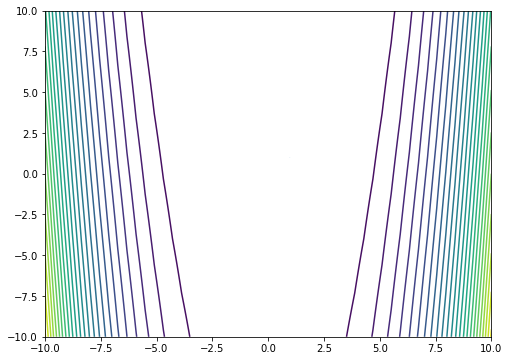

In [248]:
anim = animate_neldermead(-10,10)
HTML(anim)

In [ ]:
low,high = -2,2
x = y = np.linspace(low,high)
grid =np.meshgrid(x,y)
z = rosenbrock_1(grid)
fig,ax = plt.subplots(figsize=(8,6))


model = NelderMead(100)
best,points = model.optimize(f,[low,low],[high,high],True)
def init():
    ax.contour(x,y,z,levels = 25)
    poly = Polygon(points[0],True)
    ax.add_patch(poly)
def animate(i):
    del(ax.patches[0])
    poly = Polygon(points[i],True)
    ax.add_patch(poly)

ani = animation.FuncAnimation(fig, animate, init_func=init, 
                              frames=len(points), repeat = True,interval = 200)

plt.show()

In [224]:
ax.patches

[]

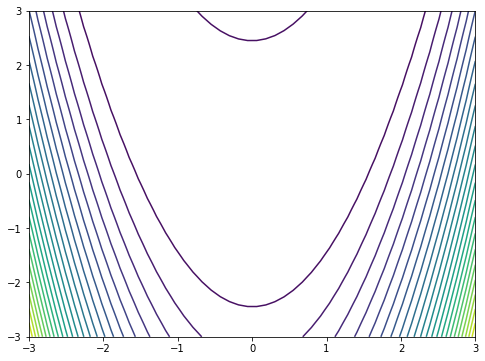

In [168]:
x = np.linspace(-3,3)
y = np.linspace(-3,3)
grid =np.meshgrid(x,y)
z = rosenbrock_1(grid)
fig,ax = plt.subplots(figsize=(8,6))
plt.contour(x,y,z,levels =25)

In [169]:
points

array([[-0.13699372, -0.07804878],
       [ 0.16164242,  2.70521064],
       [ 3.69037722,  3.6745287 ]])

In [107]:
rosenbrock_1([1,1])

0

In [82]:
grid[1].shape

(50, 50)

In [84]:
rosenbrock_1(grid).shape

(50, 50)

In [69]:
model = NelderMead(100)

In [70]:
model.optimize(rosenbrock_1,lbs,ubs)

[24582.69366638  1025.9983478   2685.03854593]
[1714.49523334 1025.9983478  2685.03854593]
[1714.49523334 1025.9983478   245.15884982]
[  65.45587788 1025.9983478   245.15884982]
[ 65.45587788   6.68050654 245.15884982]
[65.45587788  6.68050654 22.21465129]
[13.71135226  6.68050654 22.21465129]
[13.71135226  6.68050654 10.90850672]
[ 1.62130997  6.68050654 10.90850672]
[1.62130997 6.68050654 2.48024074]
[1.62130997 8.40755403 1.13590858]
[1.62130997 6.49011705 1.13590858]
[1.62130997 2.42984939 1.13590858]
[1.62130997 1.28749602 1.13590858]
[1.32095883 1.28749602 1.13590858]
[1.24949248 1.28749602 1.13590858]
[1.24949248 1.20437991 1.13590858]
[1.1889773  1.169027   1.13590858]
[1.16162224 1.15221249 1.13590858]
[1.14857314 1.14399949 1.13590858]
[1.14219435 1.1399391  1.13590858]
[1.13904003 1.13792015 1.13590858]
[1.13747147 1.13691345 1.13590858]
[1.13668932 1.13641078 1.13590858]
[1.13629877 1.13615962 1.13590858]
[1.13610363 1.13603409 1.13590858]
[1.13600609 1.13597133 1.13590858

array([-0.05508051, -0.0120372 ])

## References

In [39]:
lbs = [-2,-2]
ubs = [4,4]
dim = len(lbs)

In [13]:
f = rosenbrock_1

In [41]:
points = np.random.uniform(lbs,ubs,size = (dim+1,dim))
f_values = np.array([f(i) for i in points])
f_values

array([2.23008970e+00, 7.18451075e+02, 9.89625846e+03])

In [42]:
points

array([[-0.13699372, -0.07804878],
       [ 0.16164242,  2.70521064],
       [ 3.69037722,  3.6745287 ]])

In [28]:
points[0] = [1,1]

In [29]:
points

array([[ 1.        ,  1.        ],
       [ 0.6313679 , -0.81747338],
       [-1.58687381, -1.92134509]])

In [22]:
order = np.argsort(f_values)

In [23]:
order

array([2, 0, 1], dtype=int64)

In [71]:
np.vectorize(rosenbrock_1)(points)

IndexError: invalid index to scalar variable.

In [30]:
 hi = [1,2,3,4]

In [31]:
hi[:-1]

[1, 2, 3]